# Complex Convolutional Neural Network (CNN)

In [1]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import os
import h5py

In [2]:
print(tf.__version__)

2.3.0


In [3]:
# X training
f = h5py.File("./X_training_serial_balanced.h5","r")
print(f.keys())
train_images = f['training_d'][:].astype('float32')
f.close()
train_images[np.isnan(train_images)] = 0.

# Y training
f = h5py.File("./Y_training_serial_balanced.h5","r")
print(f.keys())
train_labels = f['train_labels_d'][:].astype(int)
f.close()

# X validation
f = h5py.File("./X_validation.h5","r")
val_images = f['validation'][:]
f.close()
val_images[np.isnan(val_images)] = 0.

# Y validation
f = h5py.File("./Y_validation.h5","r")
val_labels = f['val_labels'][:].astype(int)
f.close()

# X testing
f = h5py.File("./X_testing.h5","r")
test_images = f['testing'][:]
f.close()
test_images[np.isnan(test_images)] = 0.

# Y testing
f = h5py.File("./Y_testing.h5","r")
test_labels = f['test_labels'][:].astype(int)
f.close()


<KeysViewHDF5 ['training_d']>
<KeysViewHDF5 ['train_labels_d']>


In [4]:
# Number of occurences of each class that occur before
a = np.unique(train_labels,return_counts =1, return_index=1, return_inverse = 1)
print(a[3])

print(train_labels[3:13])


[22540 22540 22540 22540 22540]
[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]]


In [5]:
print(train_images[0][16][16][0])
print(type(train_images[0][16][16][0]))

0.024730772
<class 'numpy.float32'>


# Model

In [6]:
# Simple CNN Network
from tensorflow.keras.layers import TimeDistributed

model = models.Sequential()
model.add(layers.Conv2D(32, kernel_size = (2, 2), strides = (2,2), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.Conv2D(64, kernel_size = (2, 2), strides = (2,2), activation='relu'))
model.add(layers.Conv2D(64, kernel_size = (2, 2), strides = (2,2), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(5, activation='softmax'))


from tensorflow.keras.optimizers import SGD
model.compile(optimizer=SGD(learning_rate=0.01),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 32)        416       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 64)          8256      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          16448     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 5125      
Total params: 30,245
Trainable params: 30,245
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
14088/14088 [==============================] - 43s 3ms/step - loss: 1.5851 - accuracy: 0.2578 - val_loss: 1.6051 - val_accuracy: 0.2928
Epoch 2/20
14088/14088 [==============================] - 39s 3ms/step - loss: 1.5587 - accuracy: 0.2880 - val_loss: 1.7338 - val_accuracy: 0.2289
Epoch 3/20
14088/14088 [==============================] - 40s 3ms/step - loss: 1.5393 - accuracy: 0.3049 - val_loss: 1.6596 - val_accuracy: 0.2906
Epoch 4/20
14088/14088 [==============================] - 38s 3ms/step - loss: 1.5243 - accuracy: 0.3138 - val_loss: 1.8121 - val_accuracy: 0.1861
Epoch 5/20
14088/14088 [==============================] - 38s 3ms/step - loss: 1.5115 - accuracy: 0.3215 - val_loss: 1.8338 - val_accuracy: 0.1850
Epoch 6/20
14088/14088 [==============================] - 40s 3ms/step - loss: 1.5011 - accuracy: 0.3301 - val_loss: 1.7628 - val_accuracy: 0.2233
Epoch 7/20
14088/14088 [==============================] - 41s 3ms/step - loss: 1.4929 - accuracy: 0.3343 - val_loss: 1

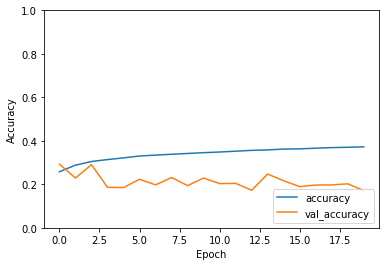

In [7]:
from tensorflow.keras.optimizers import SGD

history = model.fit(train_images, train_labels, epochs=20, batch_size = 8,
                    validation_data=(val_images, val_labels), shuffle=True)

print("\n")
# Predict on the test images
predictions = model.predict(test_images)
# Print our model's predictions.
predicts = np.argmax(predictions, axis=1)
print(predicts[0:40]) 
print("\n")
# Check our predictions against the ground truths.
print(test_labels[0:40].flatten())

print("\n")
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1])
plt.legend(loc='lower right')
print("\n")
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print("\n")
print(test_acc)
print("\n")

# Number of occurences of each class that occur before
b = np.unique(predicts,return_counts =1, return_index=1, return_inverse = 1)
print(b[0])
print(b[3])

In [8]:
# Save the model
model.save("model_arch_9.h5")

In [9]:
# TFLite Section


tflite_model_name = 'MFCC_9'
# Convert Keras model to a tflite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
# Convert the model to the TensorFlow Lite format with quantization
quantize = True
if (quantize):
    def representative_dataset():
        for i in range(500):
            yield([train_images[i].reshape(1,32,32,3).astype('float32')])
    # Set the optimization flag.
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    # Enforce full-int8 quantization
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.int8  # or tf.uint8
    converter.inference_output_type = tf.int8  # or tf.uint8
    # Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset
tflite_model = converter.convert()

open(tflite_model_name + '.tflite', 'wb').write(tflite_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:\Users\Alkinoos\AppData\Local\Temp\tmp0cwakvhc\assets


39440

In [10]:
# TFLite Section


tflite_model_name = 'quant_model_9'
# Convert Keras model to a tflite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
# Convert the model to the TensorFlow Lite format with quantization
quantize = True
if (quantize):
    def representative_dataset():
        for i in range(500):
            yield([train_images[i].reshape(1,32,32,3).astype('float32')])
    # Set the optimization flag.
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    # Enforce full-int8 quantization
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.int8  # or tf.uint8
    converter.inference_output_type = tf.int8  # or tf.uint8
    # Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset
tflite_model = converter.convert()

open(tflite_model_name + '.tflite', 'wb').write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Alkinoos\AppData\Local\Temp\tmpjoav1uhu\assets


INFO:tensorflow:Assets written to: C:\Users\Alkinoos\AppData\Local\Temp\tmpjoav1uhu\assets


39440

In [11]:
# This function here takes in the model and outputs a header file we will import into the TFLite example project folder. (/Core/Inc/)
# Function: Convert some hex value into an array for C programming

def hex_to_c_array(hex_data, var_name):

    c_str = ''

    # Create header guard
    c_str += '#ifndef ' + var_name.upper() + '_H\n'
    c_str += '#define ' + var_name.upper() + '_H\n\n'

    # Add array length at top of file
    c_str += '\nunsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

    # Declare C variable
    c_str += 'unsigned char ' + var_name + '[] = {'
    hex_array = []
    for i, val in enumerate(hex_data) :

        # Construct string from hex
        hex_str = format(val, '#04x')

        # Add formatting so each line stays within 80 characters
        if (i + 1) < len(hex_data):
            hex_str += ','
        if (i + 1) % 12 == 0:
            hex_str += '\n '
        hex_array.append(hex_str)

    # Add closing brace
    c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'

    # Close out header guard
    c_str += '#endif //' + var_name.upper() + '_H'

    return c_str


c_model_name = 'MFCC_9'
# Write TFLite model to a C source (or header) file
with open(c_model_name + '.h', 'w') as file:
    file.write(hex_to_c_array(tflite_model, c_model_name))
    

tflite_interpreter = tf.lite.Interpreter(model_path=tflite_model_name + '.tflite')
tflite_interpreter.allocate_tensors()
input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])



== Input details ==
name: conv2d_input
shape: [ 1 32 32  3]
type: <class 'numpy.int8'>

== Output details ==
name: Identity
shape: [1 5]
type: <class 'numpy.int8'>
